# 📚 LangGraph Learning - Review Analyzer Practice

This is my **practice notebook** while learning **LangGraph** for building agentic AI workflows. Not a production project — just hands-on experimentation! 🧪

## 🎯 What I'm Learning

- How to build **stateful AI workflows** with LangGraph
- **Conditional routing** based on LLM outputs
- Using **structured outputs** with Pydantic models
- Connecting nodes in a **graph-based architecture**
- Integrating **Groq LLM** with LangChain

## 🧠 Concepts Practiced

| Concept | What I Learned |
|---------|----------------|
| `StateGraph` | How to define and manage state across nodes |
| `TypedDict` | Defining state schema for type safety |
| `add_node()` | Adding processing functions as graph nodes |
| `add_edge()` | Connecting nodes sequentially |
| `add_conditional_edges()` | Routing based on conditions (like if-else) |
| `with_structured_output()` | Getting structured JSON responses from LLM |

## 🔬 What This Practice Code Does

A simple review sentiment analyzer that:

```
Review Input → Detect Sentiment → Route → Generate Response
```

- **Positive review** → Thank you message
- **Negative review** → Diagnose issue → Empathetic response

## 🏗️ Graph Flow I Built

```
START
  │
  ▼
┌─────────────────┐
│ find_sentiment  │  ← Classifies positive/negative
└────────┬────────┘
         │
    ┌────┴────┐
    │ Router  │      ← Conditional branching
    └────┬────┘
         │
   ┌─────┴─────┐
   ▼           ▼
Positive    Negative
   │           │
   ▼           ▼
Thank You   Diagnosis → Response
   │           │
   └─────┬─────┘
         ▼
        END
```

## 🛠️ Setup

```bash
# Install dependencies
pip install langgraph langchain-groq langchain-core pydantic python-dotenv

# Create .env file
echo "GROQ_API_KEY=your_key_here" > .env
```

## 📝 Key Code Snippets I Practiced

### 1. Defining State
```python
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str
```

### 2. Structured Output with Pydantic
```python
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"]

structured_model = model.with_structured_output(SentimentSchema)
```

### 3. Building the Graph
```python
graph = StateGraph(ReviewState)
graph.add_node("find_sentiment", find_sentiment)
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge(START, "find_sentiment")
workflow = graph.compile()
```

### 4. Running the Workflow
```python
result = workflow.invoke({'review': "Your app is amazing!"})
print(result['response'])
```

## 📖 Resources I Used

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Groq Integration](https://python.langchain.com/docs/integrations/chat/groq)
- [Pydantic Structured Outputs](https://python.langchain.com/docs/concepts/structured_outputs/)

## 🚧 Next Steps

- [ ] Add more complex routing logic
- [ ] Try parallel node execution
- [ ] Implement human-in-the-loop
- [ ] Add memory/persistence
- [ ] Build multi-agent workflows

## 💡 Notes to Self

- `add_conditional_edges()` needs a function that returns the next node name
- State updates are **merged**, not replaced
- Always `compile()` the graph before invoking
- Groq is fast but has rate limits

---

*This is part of my Agentic AI learning journey! 🚀*

In [14]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel ,Field
from dotenv import load_dotenv 
from langchain_groq import ChatGroq
 


In [2]:
load_dotenv()
model=ChatGroq(model="openai/gpt-oss-20b")

In [4]:
class SentimentSchema(BaseModel):
    sentiment:Literal["positive","negetive"]=Field(description="sentiment of the review")

structured_model = model.with_structured_output(SentimentSchema)

In [5]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive","negetive"]
    diagnosis: dict
    response: str

In [8]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

structured_model2 = model.with_structured_output(DiagnosisSchema)

In [9]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

In [10]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [11]:
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

In [12]:
def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}



#negative response also 
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [16]:
graph=StateGraph(ReviewState)
graph.add_node("find_sentiment",find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

In [17]:
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

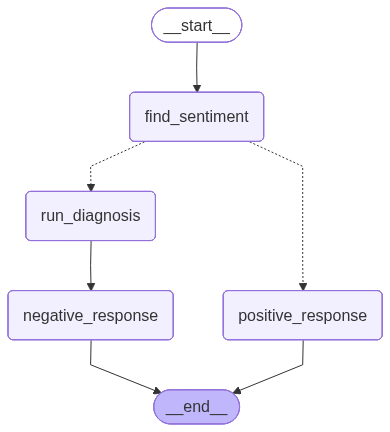

In [18]:
workflow

In [19]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negetive',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': 'Hi there,\n\nI’m really sorry you’re running into this issue – I understand how frustrating it can be when something that should work suddenly stops. I want to get this sorted out for you as quickly as possible.\n\n**Here’s what we can do right now:**\n\n1. **Quick sanity check**  \n   • Close any open applications and try restarting the program.  \n   • If it’s a web‑based tool, clear your browser cache or try a different browser.  \n   • Check for any pending updates on the app or your operating system.\n\n2. **Gather a few details (if you’re comfortable)**  \n   • What exactly happens when the bug occurs? (error messages, crash, un